In [1]:
# Import packages

import pandas as pd 
import numpy as np 
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


import plotly.express as px

import xgboost as xgb

from joblib import dump, load

pd.set_option('display.max_columns', None)

/home/ian/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [30]:
base = pd.read_csv('../data/adjusted_stats_over_under_modeling_base_df.csv')
model = load('../modeling/over_under_modeling/saved_models/ou_xg_boost_kinda_ok_av.joblib')
feature_list = [
    'passing_value_adjusted_home'
    , 'rushing_value_adjusted_home'
    , 'pass_def_value_adjusted_home'
    , 'rush_def_value_adjusted_home'
    , 'special_teams_value_home'
    , 'passing_value_adjusted_away'
    , 'rushing_value_adjusted_away'
    , 'pass_def_value_adjusted_away'
    , 'rush_def_value_adjusted_away'
    , 'special_teams_value_away'
    , 
    'total_possession_time_standardized_home'
    , 'total_possession_time_standardized_away'
    , 'total_plays_standardized_home'
    , 'total_plays_standardized_away'
    , 'pass_percentage_standardized_home'
    , 'pass_percentage_standardized_away'
    , 'total_score_line'
]

In [31]:
# Get predictions and probabilites

base = base.dropna()
features = base[feature_list].to_numpy()

# Get win predictions/probabilities

win_preds = model.predict(features)
win_probs = model.predict_proba(features)

In [32]:
base['over_hits_pred'] = win_preds
base['over_hits_prob'] = win_probs[:,1]
base['under_hits_prob'] = win_probs[:,0]

In [33]:
base

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob
32,32,2014-09-21,2014,3,REG,New England Patriots,Las Vegas Raiders,16,9,Tom Brady,Derek Carr,0.387129,-0.120190,1.178166,0.163060,1.176841,-0.702046,0.774141,-0.954522,-0.448204,-0.351268,0.096176,-1.658769,0.459249,-1.223276,-0.621252,1.143133,New England Patriots,Las Vegas Raiders,16,9,25,-901.0,704.0,-14.0,14.0,47.5,under,-7,7,away,0.900100,0.124378,home,11.10,-100.0,11.10,-100.0,-100.00,90.91,-100.00,90.91,-100.00,90.91,0,0.418961,0,0.082146,0.917854
35,35,2014-09-21,2014,3,REG,Cleveland Browns,Baltimore Ravens,21,23,Brian Hoyer,Joe Flacco,-0.137203,0.141640,0.192438,-0.869159,-0.162922,0.388264,0.048372,0.786102,-0.208942,0.137405,-0.538465,0.569921,0.548983,1.154692,-0.359257,-0.103556,Cleveland Browns,Baltimore Ravens,21,23,44,111.0,-123.0,2.0,-2.0,43.0,over,2,-2,push,0.473934,0.551570,away,81.30,-100.0,-100.00,81.3,0.00,0.00,0.00,0.00,90.91,-100.00,1,-0.631411,1,0.895059,0.104941
36,36,2014-09-21,2014,3,REG,Carolina Panthers,Pittsburgh Steelers,19,37,Cam Newton,Ben Roethlisberger,0.604152,-0.878958,0.309284,0.344995,1.301579,-0.782914,0.355480,-0.482694,-0.196212,0.017013,-0.226359,-0.542934,-0.101593,-0.281062,0.373782,0.376088,Carolina Panthers,Pittsburgh Steelers,19,37,56,-190.0,171.0,-3.0,3.0,42.5,over,18,-18,away,0.655172,0.369004,away,-100.00,171.0,-100.00,171.0,-100.00,90.91,-100.00,90.91,90.91,-100.00,1,-0.748119,1,0.913655,0.086345
37,37,2014-09-21,2014,3,REG,Arizona Cardinals,San Francisco 49ers,23,14,Drew Stanton,Colin Kaepernick,-0.857878,0.359969,-0.160789,0.607663,1.173452,-0.287031,-0.471071,-0.239934,0.452426,0.402579,-0.628596,0.317406,-0.101593,-0.415664,-0.373010,-0.511114,Arizona Cardinals,San Francisco 49ers,23,14,37,136.0,-150.0,3.0,-3.0,41.0,under,-9,9,home,0.423729,0.600000,home,-100.00,136.0,136.00,-100.0,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.098243,0,0.100330,0.899670
38,38,2014-09-21,2014,3,REG,Buffalo Bills,Los Angeles Chargers,10,22,EJ Manuel,Philip Rivers,0.531544,-0.912222,0.256764,0.606452,1.562575,0.804905,-0.212663,-0.100618,-0.538650,1.051236,-0.198053,1.406425,-0.370797,0.593851,-1.418698,-0.429705,Buffalo Bills,Los Angeles Chargers,10,22,32,-130.0,118.0,-2.5,2.5,45.5,under,12,-12,away,0.565217,0.458716,away,-100.00,118.0,-100.00,118.0,-100.00,90.91,-100.00,90.91,-100.00,90.91,0,-0.047871,0,0.176425,0.823575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.193354,-0.495465,-0.305645,0.291335,0.428766,0.784537,0.234912,-0.330543,-0.315440,Philadelphia Eagles,New York Giants,38,7,45,-380.0,300.0,-8.0,8.0,48.0,under,-31,31,home,0.791667,0.250000,home,26.32,

In [34]:
# Set what part of the data to analyze
# Most models will just look at the test set (2022 for now)
# For models with very low overfitting, could be fruitful to look at the results on the entire data set though

# analysis_df = base[base.season != 2022]
analysis_df = base[base.season == 2022]
analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.over_hits == x.over_hits_pred else 0, axis=1)
analysis_df.head()

/tmp/ipykernel_214537/626107209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['pred_correct'] = analysis_df.apply(lambda x: 1 if x.over_hits == x.over_hits_pred else 0, axis=1)


,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.515991,0.484009,0
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.870339,0.129661,0
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.449434,0.550566,1
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,1,0.679158,0.320842,1
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,0,0.253995,0.746005,1


In [35]:
# Get general accuracy measurements

accuracy = accuracy_score(analysis_df.over_hits, analysis_df.over_hits_pred)
tn, fp, fn, tp = confusion_matrix(analysis_df.over_hits, analysis_df.over_hits_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print()
print('True Positive Rate: {}'.format(tp/(tp+fn)))
print('False Positive Rate: {}'.format(fp/(fp+tn)))
print('True Negative Rate: {}'.format(tn/(tn+fp)))
print('False Negative Rate: {}'.format(fn/(fn+tp)))

Accuracy: 0.5583333333333333
Precision: 0.5166666666666667
Recall: 0.5636363636363636

True Positive Rate: 0.5636363636363636
False Positive Rate: 0.4461538461538462
True Negative Rate: 0.5538461538461539
False Negative Rate: 0.43636363636363634


<Axes: >

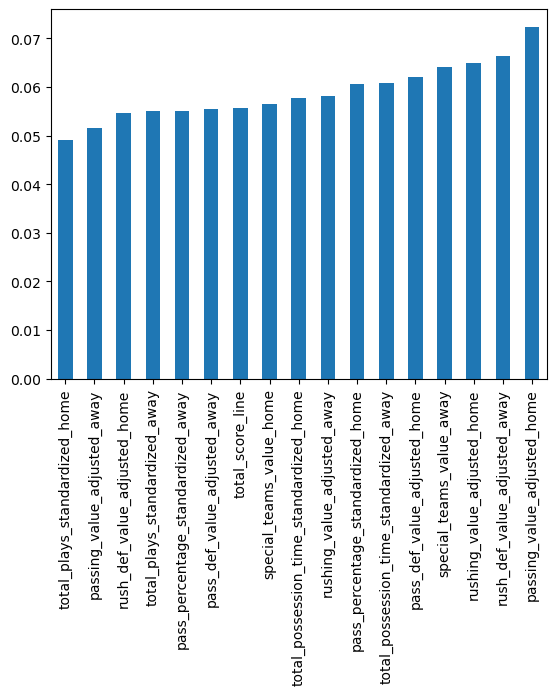

In [36]:
# Feature Importance

importances = pd.Series(model.feature_importances_, index = feature_list).sort_values()
importances.plot.bar()

In [37]:
# Get NFL translated accuracy stats

over_hits_pct = sum(analysis_df.over_hits==1)/len(analysis_df)
under_hits_pct = sum(analysis_df.over_hits==0)/len(analysis_df)

over_hits_pred_pct = sum(analysis_df.over_hits_pred==1)/len(analysis_df)
under_hits_pred_pct = sum(analysis_df.over_hits_pred==0)/len(analysis_df)

print('Over Hits Percentage: {}'.format(over_hits_pct))
print('Under Hits Percentage: {}'.format(under_hits_pct))
print('Over Hits Predicted Percentage: {}'.format(over_hits_pred_pct))
print('Under Hits Predicted Percentage: {}'.format(under_hits_pred_pct))

Over Hits Percentage: 0.4583333333333333
Under Hits Percentage: 0.5416666666666666
Over Hits Predicted Percentage: 0.5
Under Hits Predicted Percentage: 0.5


In [38]:
overs = analysis_df[analysis_df.over_hits==1]
unders = analysis_df[analysis_df.over_hits==0]

overs_acc = accuracy_score(overs.over_hits, overs.over_hits_pred)
unders_acc = accuracy_score(unders.over_hits, unders.over_hits_pred)

overs_pred = analysis_df[analysis_df.over_hits_pred==1]
unders_pred = analysis_df[analysis_df.over_hits_pred==0]

overs_pred_acc = accuracy_score(overs_pred.over_hits, overs_pred.over_hits_pred)
unders_pred_acc = accuracy_score(unders_pred.over_hits, unders_pred.over_hits_pred)

print('Accuracy for Over Hits: {}'.format(overs_acc))
print('Accuracy for Under Hits: {}'.format(unders_acc))
print()
print('Accuracy for Over Predicted: {}'.format(overs_pred_acc))
print('Accuracy for Unders Predicted: {}'.format(unders_pred_acc))

Accuracy for Over Hits: 0.5636363636363636
Accuracy for Under Hits: 0.5538461538461539

Accuracy for Over Predicted: 0.5166666666666667
Accuracy for Unders Predicted: 0.6


<Axes: xlabel='over_hits_prob', ylabel='over_hits'>

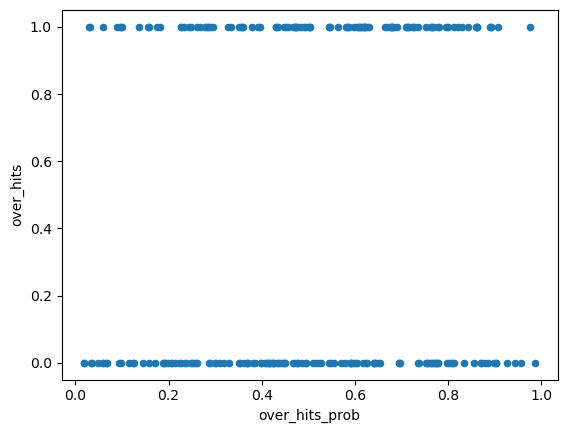

In [39]:
# Plot home win probability vs result

analysis_df.plot.scatter(x='over_hits_prob', y='over_hits')

      correct_preds  total_games  accuracy
week                                      
1                 7           10  0.700000
2                 9           14  0.642857
3                13           16  0.812500
4                 7           12  0.583333
5                 9           15  0.600000
6                 6           13  0.461538
7                 7           13  0.538462
8                 4           12  0.333333
9                 6           11  0.545455
10               11           14  0.785714
11                8           14  0.571429
12                7           13  0.538462
13                3           12  0.250000
14                6           10  0.600000
15                8           15  0.533333
16                7           14  0.500000
17                5            9  0.555556
18                6           11  0.545455
19                3            6  0.500000
20                1            4  0.250000
21                0            1  0.000000
22         

<Axes: xlabel='week'>

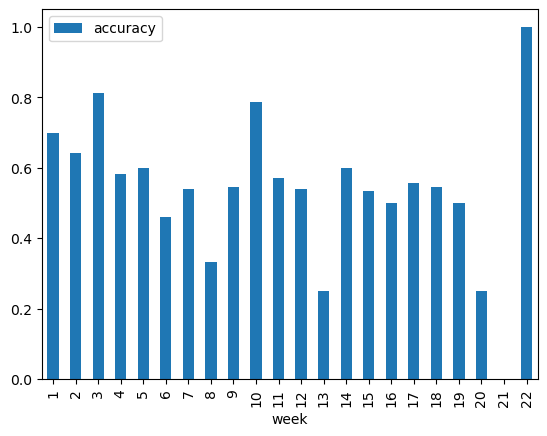

In [40]:
# Week by week accuracy

weekly = analysis_df.groupby(by='week').agg(correct_preds=('pred_correct', 'sum'), total_games=('pred_correct', 'count'))
weekly['accuracy'] = weekly.correct_preds/weekly.total_games
print(weekly)
weekly.plot.bar(y='accuracy')

In [41]:
# Average Confidence
# When correctly predicting a win, how confident were we in the prediction on average?
# Likewise, when incorrect, how confident were we?

pred_confs = analysis_df[['pred_correct', 'over_hits', 'over_hits_prob', 'under_hits_prob']].groupby(by=['pred_correct', 'over_hits']).mean()[['over_hits_prob', 'under_hits_prob']]
pred_confs

over_hits_prob  under_hits_prob
pred_correct over_hits                                 
0            0                0.722453         0.277547
             1                0.305160         0.694840
1            0                0.287119         0.712882
             1                0.702523         0.297477

In [42]:
game_with_lines = analysis_df.copy()
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.515991,0.484009,0
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.870339,0.129661,0
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.449434,0.550566,1
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,1,0.679158,0.320842,1
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,0,0.253995,0.746005,1


In [43]:
game_with_lines['over_advantage'] = game_with_lines.apply(lambda x: x.over_hits_prob-.5, axis=1)
game_with_lines['under_advantage'] = game_with_lines.apply(lambda x: x.under_hits_prob-.5, axis=1)
game_with_lines.head()

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.515991,0.484009,0,0.015991,-0.015991
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.870339,0.129661,0,0.370339,-0.370339
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.449434,0.550566,1,-0.050566,0.050566
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,1,0.679158,0.320842,1,0.179158,-0.179158
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,0,0.253995,0.746005,1,-0.246005,0.246005


In [60]:
# How does accuracy change when the confidence thresholds are adjusted?

thresholds = [0, .01, .02, .03, .05, .06, .07, .085, .1, .125, .15, .2]
thresholds = [0, .05, .10, .15, .2, .25, .3, .35, .4, .45, .5]
accuracies = []
num_games_bet = []

for threshold in thresholds:
    threshold_df = game_with_lines[np.abs(game_with_lines.over_advantage) >= threshold]
    accuracy = accuracy_score(threshold_df.over_hits, threshold_df.over_hits_pred)
    
    accuracies.append(accuracy)
    num_games_bet.append(len(threshold_df))

/home/ian/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [61]:
# How does accuracy change when the confidence thresholds are adjusted for overs and unders?

thresholds = [0, .01, .02, .03, .05, .06, .07, .085, .1, .125, .15, .2]
thresholds = [0, .05, .10, .15, .2, .25, .3, .35, .4, .45, .5]
over_accuracies = []
num_games_bet_over = []

for threshold in thresholds:
    threshold_df = game_with_lines[np.abs(game_with_lines.over_advantage) >= threshold]
    threshold_df = threshold_df[threshold_df.over_hits_pred ==1]
    accuracy = accuracy_score(threshold_df.over_hits, threshold_df.over_hits_pred)
    
    over_accuracies.append(accuracy)
    num_games_bet_over.append(len(threshold_df))

/home/ian/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [62]:
# How does accuracy change when the confidence thresholds are adjusted for overs and unders?

thresholds = [0, .01, .02, .03, .05, .06, .07, .085, .1, .125, .15, .2]
thresholds = [0, .05, .10, .15, .2, .25, .3, .35, .4, .45, .5]
under_accuracies = []
num_games_bet_under = []

for threshold in thresholds:
    threshold_df = game_with_lines[np.abs(game_with_lines.over_advantage) >= threshold]
    threshold_df = threshold_df[threshold_df.over_hits_pred ==0]
    accuracy = accuracy_score(threshold_df.over_hits, threshold_df.over_hits_pred)
    
    under_accuracies.append(accuracy)
    num_games_bet_under.append(len(threshold_df))

/home/ian/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ian/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [63]:
accuracies

[0.5583333333333333,
 0.5761904761904761,
 0.5617977528089888,
 0.5602836879432624,
 0.5454545454545454,
 0.5257731958762887,
 0.5396825396825397,
 0.5454545454545454,
 0.52,
 0.6,
 nan]

In [64]:
accuracy_list = accuracies

for i in range(0, len(thresholds)):
    print('{},       {},           {}'.format(np.round(thresholds[i], 2), np.round(accuracy_list[i], 2), num_games_bet[i]))

0,       0.56,           240
0.05,       0.58,           210
0.1,       0.56,           178
0.15,       0.56,           141
0.2,       0.55,           121
0.25,       0.53,           97
0.3,       0.54,           63
0.35,       0.55,           44
0.4,       0.52,           25
0.45,       0.6,           10
0.5,       nan,           0


In [81]:
def get_algo_returns(game, threshold):
    if game.over_advantage > game.under_advantage:
        bet_team = 'over'
        bet_advantage = game.over_advantage
    else:
        bet_team = 'under'
        bet_advantage = game.under_advantage
        
    if bet_advantage < threshold:
        return 0 
    
    else:
        return game['{}_return'.format(bet_team)]
    
    
threshold_var=.07
threshold = threshold_var

game_with_lines['algo_return'] = game_with_lines.apply(lambda x: get_algo_returns(x, threshold), axis=1)

In [82]:
game_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.515991,0.484009,0,0.015991,-0.015991,0.00
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.870339,0.129661,0,0.370339,-0.370339,-100.00
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.449434,0.550566,1,-0.050566,0.050566,0.00
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,1,0.679158,0.320842,1,0.179158,-0.179158,90.91
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,0,0.253995,0.746005,1,-0.246005,0.246005,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York Giants,38,7,Jalen Hurts,Daniel Jones,-0.064103,1.383454,0.238265,-0.015817,0.227185,0.511665,1.405749,0.1933

In [83]:
# Test Season total return

# test_with_lines = game_with_lines[game_with_lines.season != 2022]
test_with_lines = game_with_lines[game_with_lines.season == 2022]

sum(test_with_lines.algo_return)

1963.740000000002

/tmp/ipykernel_214537/1829231814.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()


<Axes: xlabel='week'>

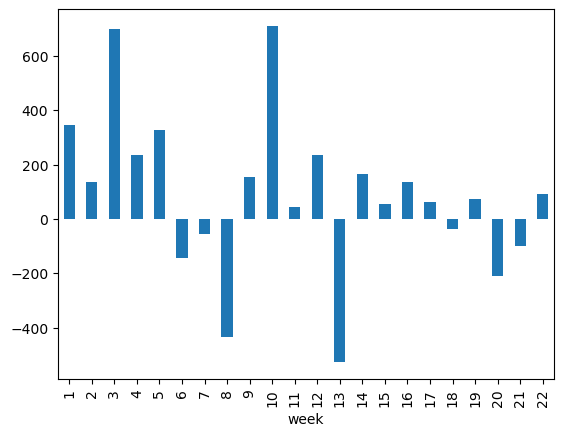

In [84]:
# Week by week return 
test_with_lines.groupby(by='week').sum()['algo_return'].plot.bar()

/tmp/ipykernel_270458/1502147613.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='season'>

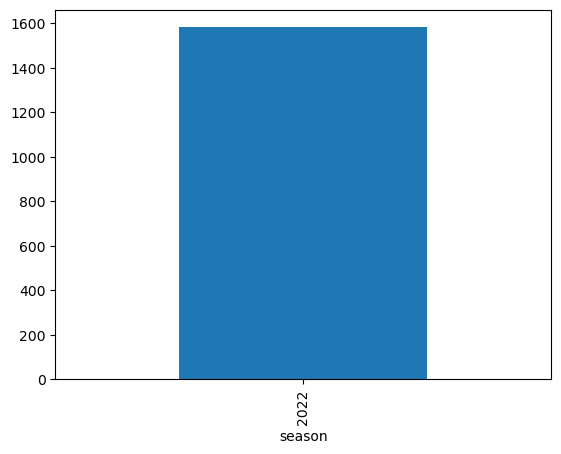

In [287]:
# Season by season return 
test_with_lines.groupby(by='season').sum()['algo_return'].plot.bar()

In [288]:
test_with_lines[test_with_lines.week == 9]

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return
2218,2247,2022-11-03,2022,9,REG,Houston Texans,Philadelphia Eagles,17,29,Davis Mills,Jalen Hurts,-0.326857,0.601305,-0.317272,-0.673932,0.135103,0.490893,0.823709,0.692349,-0.812650,0.359468,-0.178128,0.347015,-0.522224,-0.011858,0.185882,-0.621678,Houston Texans,Philadelphia Eagles,17,29,46,550.0,-833.0,14.0,-14.0,45.5,over,12,-12,home,0.153846,0.892819,away,12.00,-100.0,-100.00,12.00,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,-0.047871,0,0.450857,0.549143,0,-0.049143,0.049143,-100.00
2219,2248,2022-11-06,2022,9,REG,Chicago Bears,Miami Dolphins,32,35,Justin Fields,Tua Tagovailoa,-0.658059,1.066110,-0.144549,-0.933052,0.475565,1.052800,0.037077,-0.125609,-0.401633,-0.376366,0.663218,-0.201033,0.257346,-0.628784,-1.549414,0.257672,Chicago Bears,Miami Dolphins,32,35,67,165.0,-185.0,4.0,-4.0,46.0,over,3,-3,home,0.377358,0.649123,away,54.05,-100.0,-100.00,54.05,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.068837,1,0.829331,0.170669,1,0.329331,-0.329331,90.91
2220,2249,2022-11-06,2022,9,REG,Washington Football Team,Minnesota Vikings,17,20,Taylor Heinicke,Kirk Cousins,-0.450986,0.082502,0.386707,-0.184862,0.084887,-0.140009,0.399190,0.049527,0.425651,-0.072509,0.480722,-0.093211,0.027401,0.049834,-0.750867,0.281040,Washington Football Team,Minnesota Vikings,17,20,37,145.0,-167.0,3.0,-3.0,43.5,under,3,-3,push,0.408163,0.625468,away,59.88,-100.0,-100.00,59.88,0.00,0.00,0.00,0.00,-100.00,90.91,0,-0.514703,0,0.234372,0.765628,1,-0.265628,0.265628,90.91
2221,2250,2022-11-06,2022,9,REG,New York Jets,Buffalo Bills,20,17,Zach Wilson,Josh Allen,-0.500462,0.168845,0.676616,0.293947,-0.155008,0.504940,0.904304,0.221205,-0.346954,0.756668,-0.553363,-0.717609,-0.757777,-0.281062,-0.161741,0.056793,New York Jets,Buffalo Bills,20,17,37,425.0,-556.0,10.5,-10.5,46.0,under,-3,3,home,0.190476,0.847561,home,-100.00,425.0,425.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,0.068837,1,0.778996,0.221004,0,0.278996,-0.278996,-100.00
2222,2251,2022-11-06,2022,9,REG,New England Patriots,Indianapolis Colts,26,3,Mac Jones,Sam Ehlinger,-0.321911,0.343414,0.354209,0.383689,0.745840,0.105051,-1.104190,-0.082563,0.243010,0.178876,0.389473,-0.222634,0.352689,-0.998939,-0.137337,-1.112900,New England Patriots,Indianapolis Colts,26,3,29,-233.0,190.0,-5.0,5.0,40.0,under,-23,23,home,0.699700,0.344828,home,42.92,-100.0,42.92,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,-1.331659,0,0.018874,0.981126,1,-0.481126,0.481126,90.91
2223,2252,2022-11-06,2022,9,REG,Detroit Lions,Green Bay Packers,15,9,Jared Goff,Aaron Rodgers,-0.290674,-0.195708,-1.071432,-0.516376,0.105475,-0.301369,0.071969,-0.079011,-0.564353,-0.686464,-0.471053,-0.010343,-0.443706,-0.320321,0.179771,0.390119,Detroit Lions,Green Bay Packers,15,9,24,167.0,-192.0,4.0,-4.0,49.5,under,-6,6,home,0.374532,0.657534,home,-100.00,167.0,167.00,-100.00,-100.00,90.91,90.91,-100.00

In [289]:
# Should move these to helper functions later

def get_algo_returns_over(game, threshold):
    if game.over_advantage < threshold:
        return 0 
    
    else:
        return game.over_return
    
def get_algo_returns_under(game, threshold):
    if game.under_advantage < threshold:
        return 0 
    
    else:
        return game.under_return
    
threshold = threshold_var

test_with_lines['algo_return_overs'] = test_with_lines.apply(lambda x: get_algo_returns_over(x, threshold), axis=1)
test_with_lines['algo_return_unders'] = test_with_lines.apply(lambda x: get_algo_returns_under(x, threshold), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return,algo_return_overs,algo_return_unders
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.515991,0.484009,0,0.015991,-0.015991,-100.00,-100.00,0.00
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.870339,0.129661,0,0.370339,-0.370339,-100.00,-100.00,0.00
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.449434,0.550566,1,-0.050566,0.050566,90.91,0.00,90.91
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,1,0.679158,0.320842,1,0.179158,-0.179158,90.91,90.91,0.00
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,0,0.253995,0.746005,1,-0.246005,0.246005,90.91,0.00,90.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01-21,2022,20,POST,Philadelphia Eagles,New York 

In [290]:
# Look at outcomes by home, away, favorite, underdog, etc.

test_pivoted = test_with_lines.copy().reset_index()
test_pivoted = test_pivoted.groupby(by='week').sum().reset_index()
test_pivoted = pd.melt(test_pivoted, id_vars = ['week'],
              value_vars=['algo_return_overs', 'algo_return_unders'],
             var_name='algo_return_type', value_name='return')
test_pivoted

/tmp/ipykernel_270458/35314960.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,week,algo_return_type,return
0,1,algo_return_overs,-118.18
1,2,algo_return_overs,-27.27
2,3,algo_return_overs,436.37
3,4,algo_return_overs,-27.27
4,5,algo_return_overs,-36.36
5,6,algo_return_overs,-327.27
6,7,algo_return_overs,-18.18
7,8,algo_return_overs,-118.18
8,9,algo_return_overs,-209.09
9,10,algo_return_overs,336.37


<Axes: >

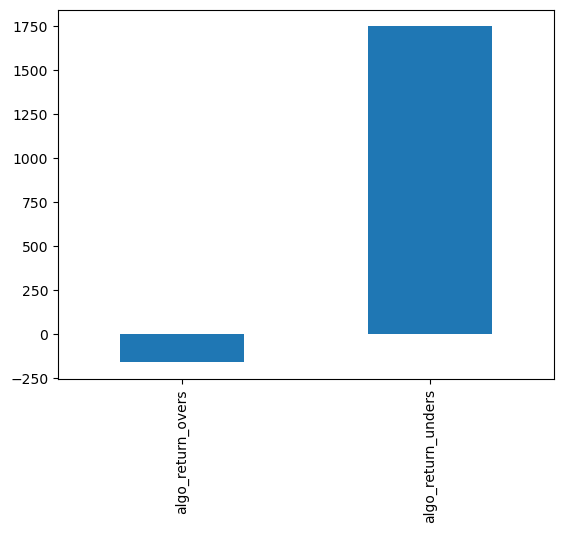

In [291]:
test_with_lines.sum()[['algo_return_overs', 'algo_return_unders']].plot.bar()

In [230]:
# Week by week return 

fig = px.bar(test_pivoted, x="week", y="return", color='algo_return_type')
fig.show()

In [213]:
# Get accuracies 

def get_algo_acc(game, column):
    if game[column] > 0:
        return 1
    elif game[column] < 0:
        return 0 
    else:
        return None

test_with_lines['algo_overs_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_overs'), axis=1)
test_with_lines['algo_unders_acc'] = test_with_lines.apply(lambda x: get_algo_acc(x, 'algo_return_unders'), axis=1)
test_with_lines

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return,algo_return_overs,algo_return_unders,algo_overs_acc,algo_unders_acc
2097,2124,2022-09-08,2022,1,REG,Los Angeles Rams,Buffalo Bills,10,31,Matthew Stafford,Josh Allen,0.881049,-1.629130,0.599551,0.198086,0.245513,1.027059,1.717083,0.371247,-0.433831,-0.321618,0.722622,0.394501,0.520941,0.038617,-0.030552,-0.319587,Los Angeles Rams,Buffalo Bills,10,31,41,110.0,-132.0,2.0,-2.0,52.0,under,21,-21,away,0.476190,0.568966,away,75.76,-100.0,-100.00,75.76,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,1.469333,1,0.653848,0.346152,0,0.153848,-0.153848,0.0,0.0,0.0,NaN,NaN
2098,2125,2022-09-11,2022,1,REG,Miami Dolphins,New England Patriots,20,7,Tua Tagovailoa,Mac Jones,-0.287325,-0.398164,0.483910,-0.445514,-0.482618,0.385360,0.681829,-0.627966,-1.545089,-0.130771,0.526532,-0.259879,0.156394,-0.303496,-0.871415,-0.052171,Miami Dolphins,New England Patriots,20,7,27,-172.0,150.0,-3.0,3.0,46.5,under,-13,13,home,0.632353,0.400000,home,58.14,-100.0,58.14,-100.00,90.91,-100.00,90.91,-100.00,-100.00,90.91,0,0.185545,1,0.705725,0.294275,0,0.205725,-0.205725,0.0,0.0,0.0,NaN,NaN
2101,2128,2022-09-11,2022,1,REG,New York Jets,Baltimore Ravens,9,24,Joe Flacco,Lamar Jackson,0.052524,0.277120,-0.324429,-0.228931,0.658283,-0.515382,0.310554,-0.851114,0.376529,0.583904,-0.987443,1.468809,-0.841904,1.188342,0.407590,-0.075841,New York Jets,Baltimore Ravens,9,24,33,240.0,-303.0,6.5,-6.5,44.0,under,15,-15,away,0.294118,0.751861,away,33.00,-100.0,-100.00,33.00,90.91,-100.00,-100.00,90.91,-100.00,90.91,0,-0.397995,0,0.252908,0.747092,1,-0.247092,0.247092,0.0,0.0,0.0,NaN,NaN
2104,2131,2022-09-11,2022,1,REG,Detroit Lions,Philadelphia Eagles,35,38,Jared Goff,Jalen Hurts,0.605529,-0.605198,-0.209866,-0.976836,-0.071445,0.049749,0.392195,-0.571778,-0.392968,-0.497614,-0.485020,-0.016116,-0.224978,-0.135243,-0.236068,-0.331271,Detroit Lions,Philadelphia Eagles,35,38,73,195.0,-238.0,5.5,-5.5,48.5,over,3,-3,home,0.338983,0.704142,away,42.02,-100.0,-100.00,42.02,-100.00,90.91,90.91,-100.00,90.91,-100.00,1,0.652377,0,0.171893,0.828107,0,-0.328107,0.328107,0.0,0.0,0.0,NaN,NaN
2105,2132,2022-09-11,2022,1,REG,Chicago Bears,San Francisco 49ers,19,10,Justin Fields,Trey Lance,-0.387951,0.080787,2.042572,-0.207334,0.794918,0.266084,-0.507855,0.162268,0.683004,0.425007,-0.276266,0.026901,0.201262,-0.393230,-0.219241,-1.353506,Chicago Bears,San Francisco 49ers,19,10,29,230.0,-286.0,6.5,-6.5,38.0,under,-9,9,home,0.303030,0.740933,home,-100.00,230.0,230.00,-100.00,-100.00,90.91,90.91,-100.00,-100.00,90.91,0,-1.798491,1,0.589050,0.410950,0,0.089050,-0.089050,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2371,2401,2023-01

In [214]:
accs = test_with_lines.groupby(by='week').agg(
    algo_over_correct = ('algo_overs_acc', 'sum'),
    algo_over_total = ('algo_overs_acc', 'count'),
    algo_under_correct = ('algo_unders_acc', 'sum'),
    algo_under_total = ('algo_unders_acc', 'count'),
)

accs['algo_overs_acc'] = accs.algo_over_correct/accs.algo_over_total
accs['algo_away_acc'] = accs.algo_under_correct/accs.algo_under_total

<Axes: xlabel='week'>

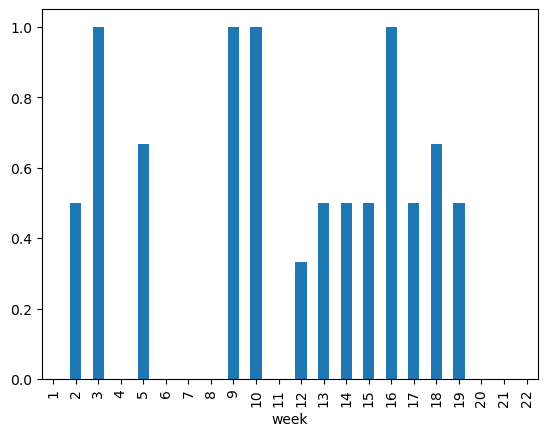

In [215]:
check_col = 'algo_overs_acc'
accs[check_col].plot.bar()

<Axes: >

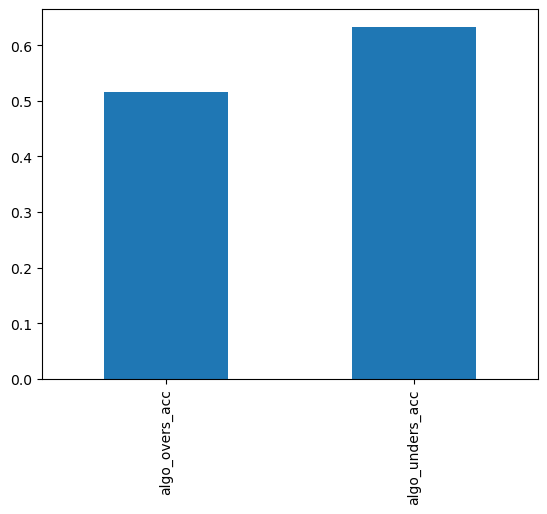

In [216]:
accs2 = test_with_lines.agg(['sum','count']).transpose().loc[['algo_overs_acc', 'algo_unders_acc']]
accs2['accuracy'] = accs2['sum']/accs2['count']
accs2.accuracy.plot.bar()

In [217]:
# Total bet counts

len(test_with_lines[test_with_lines.algo_return != 0])

63

In [218]:
test_with_lines[test_with_lines.algo_return!=0][['date', 'week', 'home_team', 'away_team', 'home_score_x', 'away_score_x', 'algo_return', 'over_advantage', 'under_advantage']]

,date,week,home_team,away_team,home_score_x,away_score_x,algo_return,over_advantage,under_advantage
2115,2022-09-18,2,Pittsburgh Steelers,New England Patriots,14,17,90.91,-0.367104,0.367104
2118,2022-09-18,2,Cleveland Browns,New York Jets,30,31,90.91,0.358552,-0.358552
2119,2022-09-18,2,New Orleans Saints,Tampa Bay Buccaneers,10,20,-100.00,0.450232,-0.450232
2120,2022-09-18,2,Detroit Lions,Washington Football Team,36,27,-100.00,-0.387829,0.387829
2124,2022-09-18,2,Denver Broncos,Houston Texans,16,9,90.91,-0.484062,0.484062
...,...,...,...,...,...,...,...,...,...
2351,2023-01-08,18,Pittsburgh Steelers,Cleveland Browns,28,14,90.91,0.425097,-0.425097
2358,2023-01-08,18,San Francisco 49ers,Arizona Cardinals,38,13,90.91,0.353736,-0.353736
2364,2023-01-14,19,San Francisco 49ers,Seattle Seahawks,41,23,90.91,0.449601,-0.449601
2369,2023-01-16,19,Tampa Bay Buccaneers,Dallas Cowboys,14,31,-100.00,0.397612,-0.397612


<Axes: >

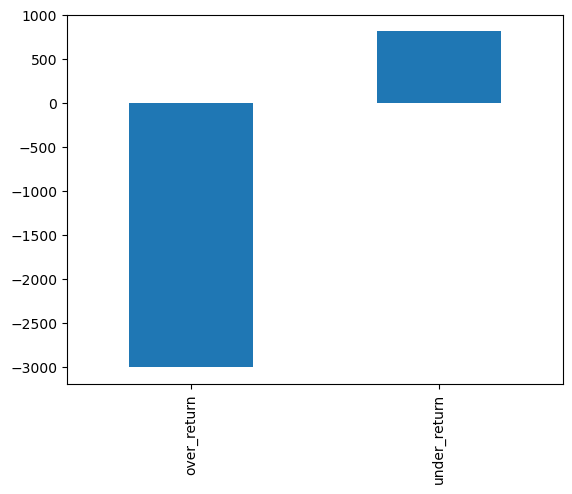

In [219]:
test_with_lines[['over_return', 'under_return']].sum().plot.bar()

In [220]:
test_with_lines[test_with_lines.pred_correct == 0].sort_values(by='under_advantage', ascending=False)

,Unnamed: 0,date,season,week,season_type,home,away,home_score_x,away_score_x,home_qb,away_qb,passing_value_adjusted_home,rushing_value_adjusted_home,pass_def_value_adjusted_home,rush_def_value_adjusted_home,special_teams_value_home,passing_value_adjusted_away,rushing_value_adjusted_away,pass_def_value_adjusted_away,rush_def_value_adjusted_away,special_teams_value_away,total_possession_time_standardized_home,total_possession_time_standardized_away,total_plays_standardized_home,total_plays_standardized_away,pass_percentage_standardized_home,pass_percentage_standardized_away,home_team,away_team,home_score_y,away_score_y,total_score_actual,home_moneyline,away_moneyline,home_spread,away_spread,total_score_line,over_under_result,home_team_actual_line,away_team_actual_line,spread_cover_result,home_implied_prob,away_implied_prob,game_winner,favorite_return,underdog_return,home_return,away_return,favorite_spread_return,underdog_spread_return,home_spread_return,away_spread_return,over_return,under_return,over_hits,total_score_standardized,over_hits_pred,over_hits_prob,under_hits_prob,pred_correct,over_advantage,under_advantage,algo_return,algo_return_overs,algo_return_unders,algo_overs_acc,algo_unders_acc
2190,2218,2022-10-20,2022,7,REG,Arizona Cardinals,New Orleans Saints,42,34,Kyler Murray,Andy Dalton,-0.398441,0.196364,0.261597,0.435653,-0.731150,0.066439,0.782500,-0.149145,0.009422,-0.315371,0.422621,0.586971,1.064957,0.597110,0.174505,-1.077148,Arizona Cardinals,New Orleans Saints,42,34,76,-141.0,120.0,-2.5,2.5,43.5,over,-8,8,home,0.585062,0.454545,home,70.92,-100.00,70.92,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,1,-0.514703,0,0.023618,0.976382,0,-0.476382,0.476382,-100.0,0.0,-100.0,NaN,0.0
2210,2238,2022-10-30,2022,8,REG,Atlanta Falcons,Carolina Panthers,37,34,Marcus Mariota,P.J. Walker,0.323657,0.587348,-0.684060,0.158334,0.113341,-0.271472,0.094417,-0.237579,0.427305,0.142060,-0.223938,-0.064719,-1.251318,-1.099891,-2.020188,-0.916508,Atlanta Falcons,Carolina Panthers,37,34,71,-200.0,170.0,-4.0,4.0,41.0,over,-3,3,away,0.666667,0.370370,home,50.00,-100.00,50.00,-100.00,-100.00,90.91,-100.00,90.91,90.91,-100.00,1,-1.098243,0,0.045144,0.954856,0,-0.454856,0.454856,-100.0,0.0,-100.0,NaN,0.0
2188,2216,2022-10-16,2022,6,REG,Philadelphia Eagles,Dallas Cowboys,26,17,Jalen Hurts,Cooper Rush,0.121108,0.639317,0.643928,0.092633,-0.163309,-0.369356,-0.021520,0.775285,-0.150321,0.728558,0.949812,-0.143118,0.806970,-0.482965,-0.876423,-1.121299,Philadelphia Eagles,Dallas Cowboys,26,17,43,-294.0,235.0,-6.5,6.5,42.5,over,-9,9,home,0.746193,0.298507,home,34.01,-100.00,34.01,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,1,-0.748119,0,0.069676,0.930324,0,-0.430324,0.430324,-100.0,0.0,-100.0,NaN,0.0
2126,2154,2022-09-19,2022,2,REG,Buffalo Bills,Tennessee Titans,41,7,Josh Allen,Ryan Tannehill,1.247523,1.017722,0.722301,-0.368096,-0.093501,0.527642,-0.437453,0.515883,-0.621069,-0.395757,0.255953,0.082395,-0.337146,-0.589525,-0.202923,-0.882657,Buffalo Bills,Tennessee Titans,41,7,48,-455.0,350.0,-10.0,10.0,47.5,over,-34,34,home,0.819820,0.222222,home,21.98,-100.00,21.98,-100.00,90.91,-100.00,90.91,-100.00,90.91,-100.00,1,0.418961,0,0.080174,0.919826,0,-0.419826,0.419826,-100.0,0.0,-100.0,NaN,0.0
2281,2310,2022-12-04,2022,13,REG,Chicago Bears,Green Bay Packers,19,28,Justin Fields,Aaron Rodgers,-0.350269,0.975389,-1.277181,0.173437,-0.449351,0.101732,0.448236,0.003265,-1.566656,-0.462765,0.782958,-0.182411,0.150786,-0.752169,-1.789966,-0.169321,Chicago Bears,Green Bay Packers,19,28,47,165.0,-185.0,3.5,-3.5,45.0,over,9,-9,away,0.377358,0.649123,away,54.05,-100.00,-100.00,54.05,90.91,-100.00,-100.00,90.91,90.91,-100.00,1,-0.164579,0,0.083037,0.916963,0,-0.416963,0.416963,-100.0,0.0,-100.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [119]:
# NOTE

do some eda, maybe 6 games isnt the best number
maybe would be good to use previous season data for the early weeks as well
can look at autocorrelation? see how the correlation between stats changes the farther the number of games is
may find that after 4 or 5 games the correlation gets very small, or maybe the opposite

SyntaxError: invalid syntax (206508906.py, line 3)